# Debate dos presidenciáveis na Globo - 1º Turno - 2018

O debate ocorreu das 22h00 até por volta de 0h40 do dia 04 de Outubro de 2018 com a presença dos seguintes presidenciáveis:
- Alvaro Dias (Podemos)
- Ciro Gomes (PDT)
- Fernando Haddad (PT)
- Geraldo Alckmin (PSDB)
- Guilherme Boulos (PSOL)
- Henrique Meirelles (MDB)
- Marina Silva (Rede)

O candidato Jair Bolsonaro (PSL) foi convidado, mas não compareceu ao debate por recomendações médicas, entretanto no mesmo horário do debate na Rede Globo o candidato deu uma entrevista na Rede Record, portanto seu nome foi considerado nesta pesquisa.
***

[Álvaro Dias](#alvaro)

Importação das bibliotecas necessárias e algumas configurações:

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy

pd.set_option('display.max_rows', 200_000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2_500)

nlp = spacy.load('pt')
nlp.max_length = 3_000_000

import warnings
warnings.filterwarnings('ignore')

D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
D:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### Dados intenção de votos aos presidenciáveis
***

Antes de começar as análises com os tweets, vamos dar uma olhada nos dados do Datafolha sobre os presidenciáveis até então. Fonte: https://www.poder360.com.br/banco-de-dados/

In [5]:
datafolha_est = pd.read_csv('datafolha_est.csv')
datafolha_rej = pd.read_csv('datafolha_rej.csv')

datafolha_est['data_pesquisa'] = datafolha_est['data_pesquisa'].apply(lambda x: pd.Timestamp(x).date())
datafolha_rej['data_pesquisa'] = datafolha_rej['data_pesquisa'].apply(lambda x: pd.Timestamp(x).date())

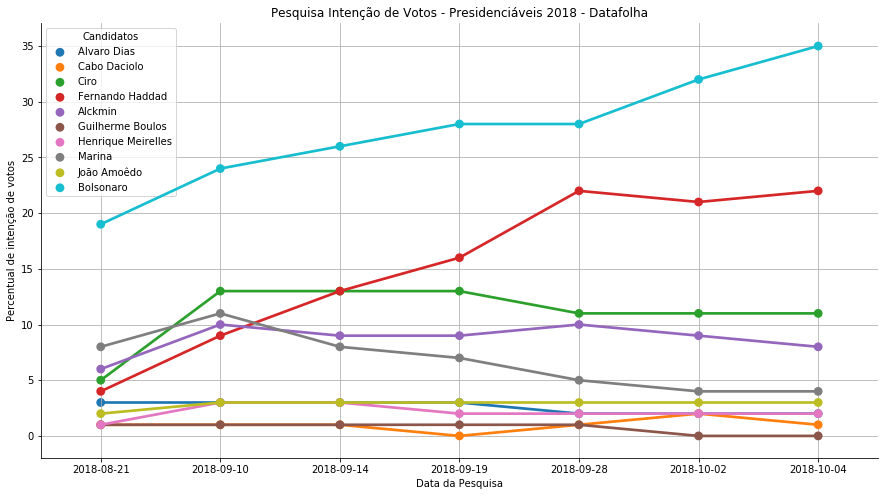

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = sns.pointplot(x='data_pesquisa',
                  y='percentual',
                  hue='candidato',
                  data=datafolha_est,
                  hue_order=['Alvaro Dias', 'Cabo Daciolo', 'Ciro', 'Fernando Haddad', 'Alckmin', 'Guilherme Boulos',
                             'Henrique Meirelles', 'Marina', 'João Amoêdo', 'Bolsonaro'],
                  ax=ax)

_ = ax.set(title='Pesquisa Intenção de Votos - Presidenciáveis 2018 - Datafolha',
           xlabel='Data da Pesquisa',
           ylabel='Percentual de intenção de votos')

_ = sns.despine()
_ = ax.grid(True)
_ = ax.legend(title='Candidatos')

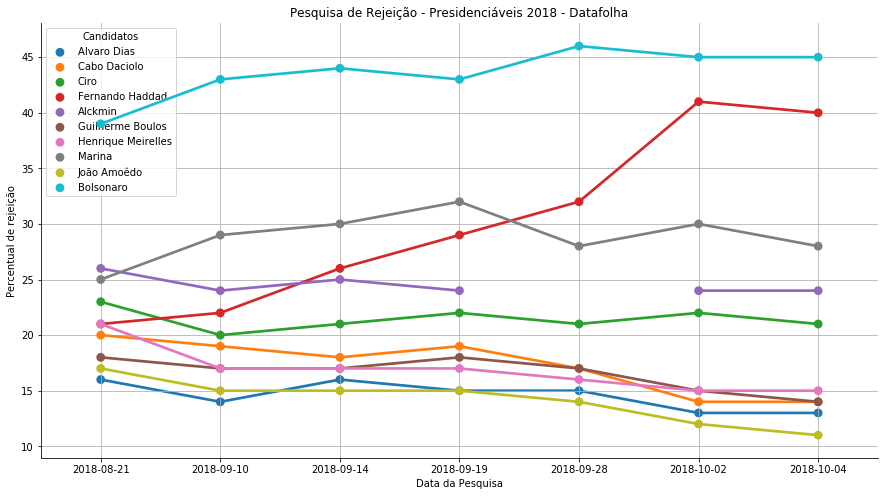

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = sns.pointplot(x='data_pesquisa',
                  y='percentual',
                  hue='candidato',
                  data=datafolha_rej,
                  hue_order=['Alvaro Dias', 'Cabo Daciolo', 'Ciro', 'Fernando Haddad', 'Alckmin', 'Guilherme Boulos',
                             'Henrique Meirelles', 'Marina', 'João Amoêdo', 'Bolsonaro'],
                  ax=ax)

_ = ax.set(title='Pesquisa de Rejeição - Presidenciáveis 2018 - Datafolha',
           xlabel='Data da Pesquisa',
           ylabel='Percentual de rejeição')

_ = sns.despine()
_ = ax.grid(True)
_ = ax.legend(title='Candidatos')

## Dados twitter durante o debate
***

In [8]:
# Leitura do dataset
tweets = pd.read_csv('../tweets_debate_globo_limpo.csv')

# Conversão da coluna 'datetime' em objeto datetime
tweets['datetime'] = tweets['datetime'].apply(pd.Timestamp)

# Adição de mais duas colunas ao dataset:'hour' e 'minute'
tweets['hour'] = tweets['datetime'].apply(lambda x: x.hour)
tweets['minute'] = tweets['datetime'].apply(lambda x: x.minute)

tweets.head()

,text,datetime,text_clean
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix
2,Boulos: A\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição
3,"O microfone do Meirelles caiu agora.\r\n\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30
4,"PROPOSTAS DE BOLSONARO\r\n- Fim do 13º e férias\r\n- Redução da licença maternidade\r\n- IR igual pra ricos e POBRES\r\n- Volta da CPMF\r\n- Fim do Bolsa Família e projetos sociais\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\n- Mais armas em circulação\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação


In [12]:
# Dimensão do dataset
tweets.shape

(508503, 5)

In [3]:
# Criação de variáveis que serão utilizadas no decorrer das análises
candidatos = ['alvaro', 'ciro', 'haddad', 'alckmin', 'boulos', 'meirelles', 'marina', 'bolsonaro']
display_candidatos = ['Álvaro Dias', 'Ciro Gomes', 'Fernando Haddad', 'Geraldo Alckmin', 'Guilherme Boulos', 'Henrique Meirelles', 'Marina Silva', 'Jair Bolsonaro']
colors = ['blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'c']
map_names = {k: v for k, v in zip(candidatos, display_candidatos)}

In [4]:
# Funções que serão utilizads nas análises
import re
from collections import Counter

def mask_palavra_texto(palavra, texto):
    padrão = r'(^|[^\w]){}([^\w]|$)'.format(palavra)
    padrão = re.compile(padrão, re.IGNORECASE)
    matches = re.search(padrão, texto)
    return bool(matches)

def plot_contagem_candidatos(df, lista_candidatos):
    contagem = []
    palette = {k: v for k, v in zip(display_candidatos, colors)}    
    for candidato in lista_candidatos:
        contagem.append(df['text'].astype(str).apply(lambda x: mask_palavra_texto(candidato, x.lower())).sum())

    plot_df = pd.DataFrame({'Candidatos': candidatos, 'Contagem': contagem}).sort_values(by='Contagem', ascending=False)
    plot_df['Candidatos'] = plot_df['Candidatos'].map(map_names)
    fig, ax = plt.subplots(figsize=(15, 8))
    _ = sns.barplot(x='Candidatos', y='Contagem', data=plot_df, ax=ax, palette=palette)
    _ = ax.set(title='Contagem de tweets em que cada candidato foi citado')
    _ = sns.despine()

def verbos_candidatos(texto, candidato, qtde=5):
    sents = [sent for sent in texto.sents if candidato in sent.string.lower()]
    char_words = []
    for sent in sents: 
        for word in sent: 
            if candidato in word.string: 
                char_words.append(word)
    char_verbs = []
    for word in char_words: 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                char_verbs.append(ancestor.lemma_.strip())
    return Counter(char_verbs).most_common(qtde)

def adjetivos_candidatos(texto, candidato, qtde=5):
    sents = [sent for sent in texto.sents if candidato in sent.string.lower()]
    char_adjs = []
    for sent in sents: 
        for word in sent: 
            for child in word.children: 
                if child.pos_ == 'ADJ':
                    char_adjs.append(child)
    return Counter(char_adjs).most_common(qtde)
                    
def frases_candidato(df, candidato, palavra, qtde=5):
    mask_cand = df['text_clean'].astype(str).apply(lambda x: mask_palavra_texto(candidato, x))
    mask_palavra = df['text_clean'].astype(str).apply(lambda x: mask_palavra_texto(palavra, x))
    return list(df[mask_cand & mask_palavra]['text'].head(qtde))

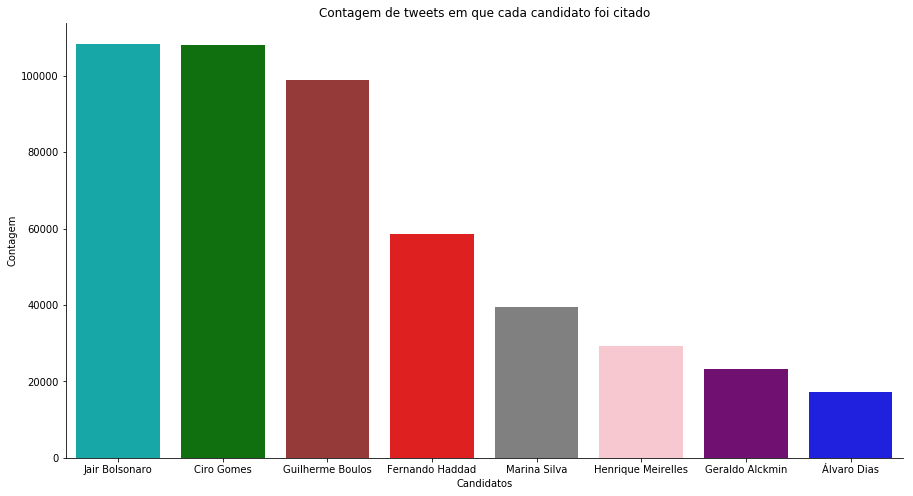

In [93]:
plot_contagem_candidatos(tweets, candidatos)

Distribuição dos tweets por candidato durante o debate:

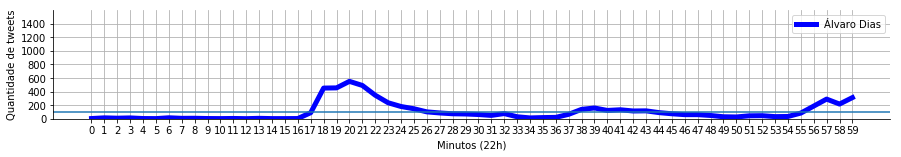

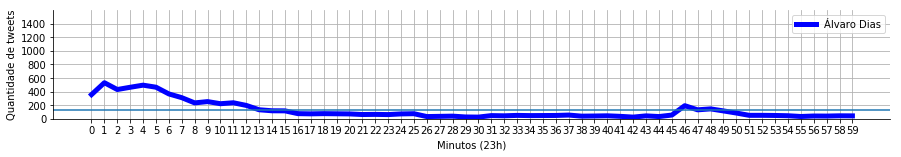

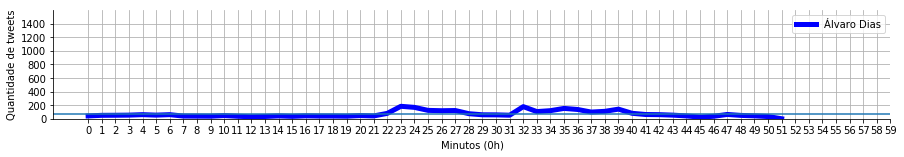

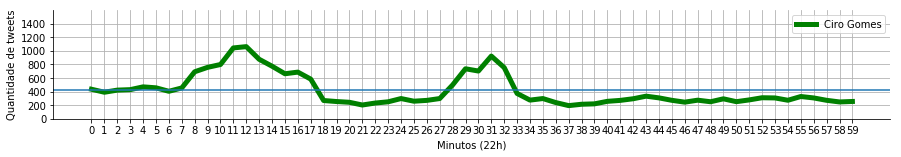

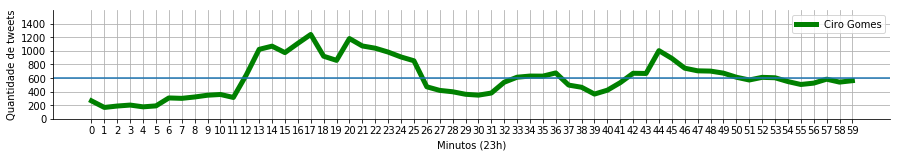

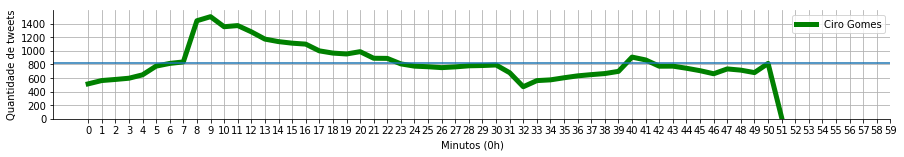

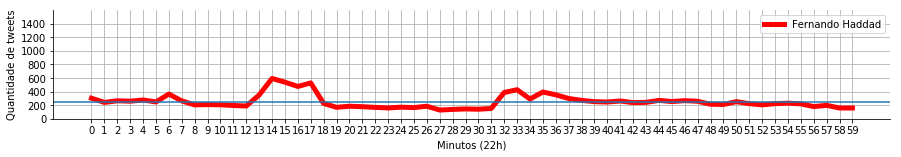

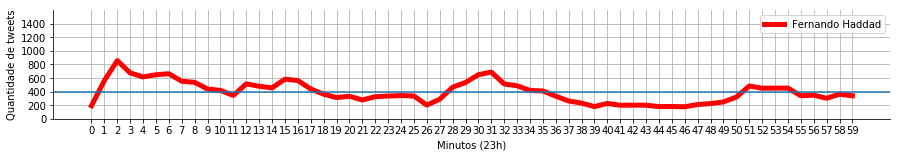

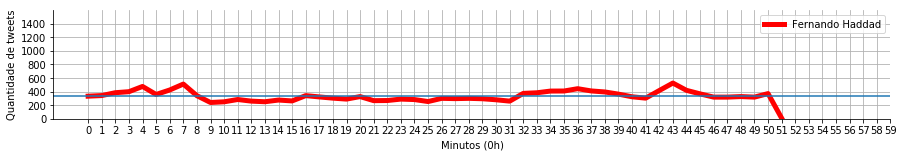

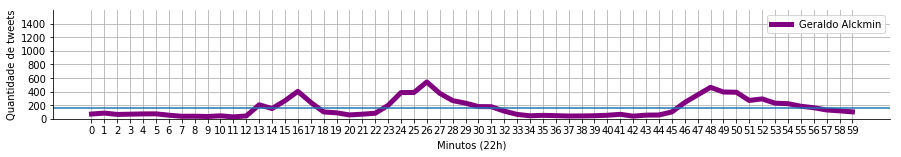

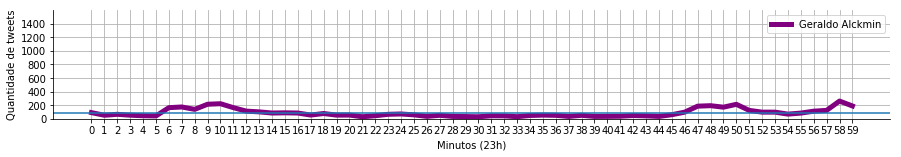

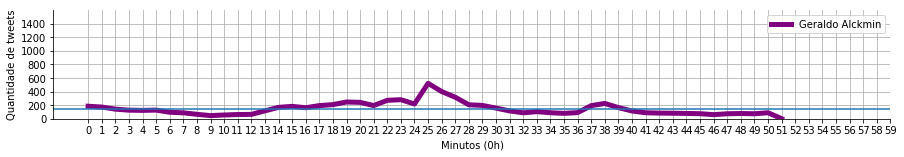

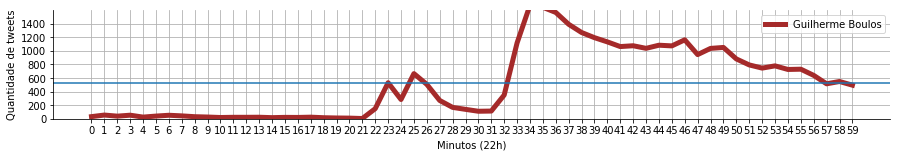

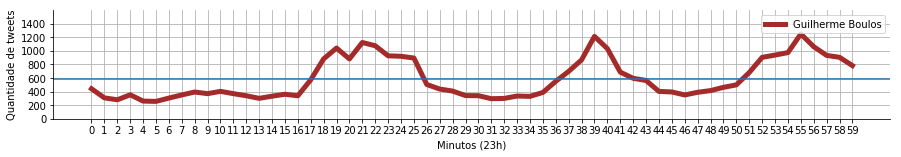

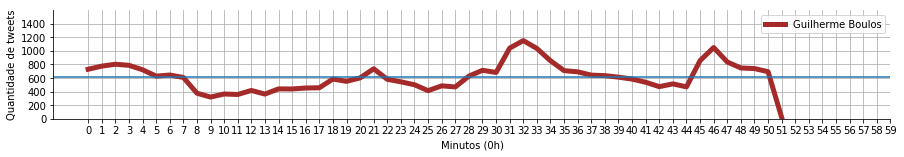

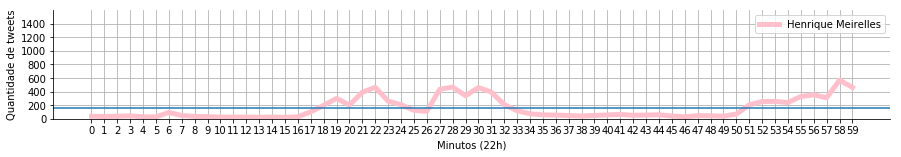

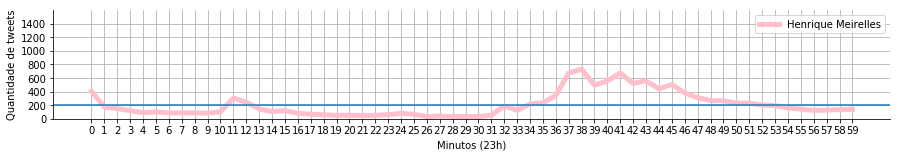

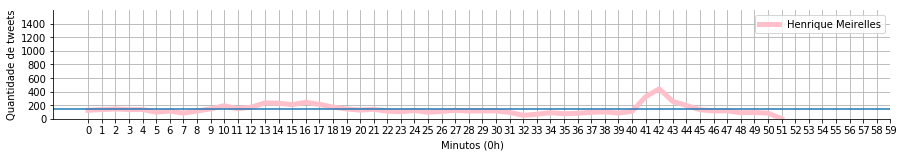

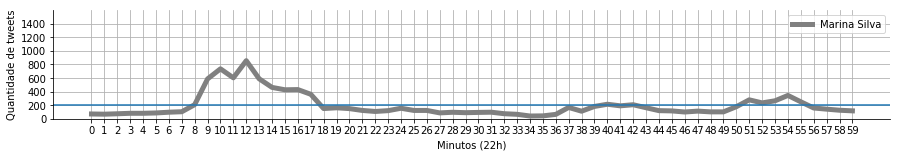

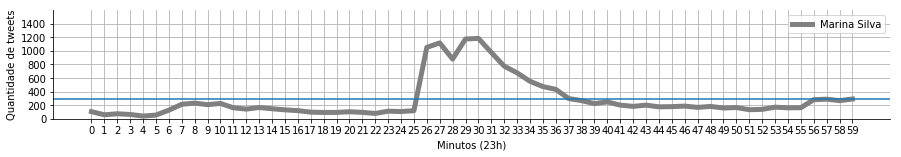

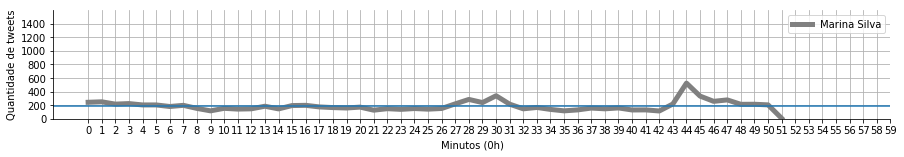

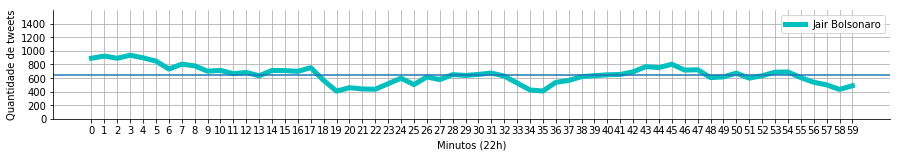

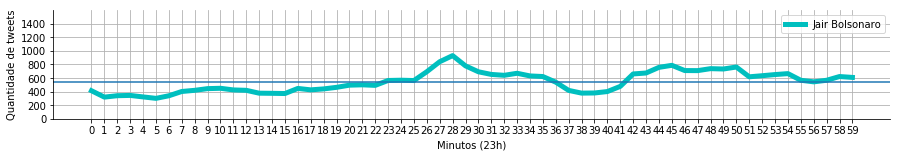

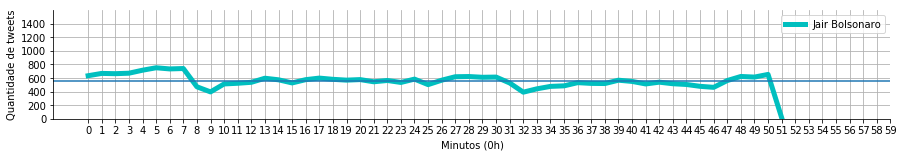

In [89]:
for candidato, c, nome in zip(candidatos, colors, display_candidatos):
    df_cand = tweets[tweets['text'].apply(lambda x: mask_palavra_texto(candidato, x))]
    for hora in [22, 23, 0]:
        fig, ax = plt.subplots(figsize=(15, 2))
        to_plot = df_cand[df_cand['hour']==hora]['minute'].value_counts().sort_index().reset_index()
        _ = sns.lineplot(x='index', y='minute', data=to_plot, ax=ax, color=c, label=nome, linewidth=5)

        _ = ax.set(xlabel='Minutos ({0}h)'.format(hora),
                   ylabel='Quantidade de tweets',
                   xticks=list(range(0, 60, 1)),
                   yticks=list(range(0, 1_500, 200)),
                   ylim=[0, 1_600])

        _ = ax.legend()
        _ = ax.grid(True)
        _ = ax.axhline(to_plot['minute'].mean())

        _ = sns.despine()
    _ = plt.subplots_adjust(hspace=0.4)

## Análise de Sentimentos
***

In [5]:
# Datasets train e holdout anteriormente tratados (notebook Preprocessing)
train = pd.read_csv('../tweets_train.csv')
holdout = pd.read_csv('../tweets_holdout.csv')

In [6]:
train.head()

,text,datetime,text_clean,sentiment
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho,0.0
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix,-1.0
2,Boulos: A\r\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição,1.0
3,"O microfone do Meirelles caiu agora.\r\r\n\r\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30,-1.0
4,"PROPOSTAS DE BOLSONARO\r\r\n- Fim do 13º e férias\r\r\n- Redução da licença maternidade\r\r\n- IR igual pra ricos e POBRES\r\r\n- Volta da CPMF\r\r\n- Fim do Bolsa Família e projetos sociais\r\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\r\n- Mais armas em circulação\r\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação,-1.0


In [7]:
holdout.head()

,text,datetime,text_clean
0,álvaro dias perguntando pro meirelzzZZZzzzzZZzzZZZzz,2018-10-04 22:18:06+00:00,álvaro perguntar pro meirelzzzzzzzzzzzzzzzzzz
1,Ninguém falou sobre isso até agora no debate. Acabar com desmatamento tão importante quanto reduzir emissões. https://t.co/2MFFikdbFW,2018-10-04 23:12:08+00:00,ninguém falar sobrar o debater acabar desmatamento importante quantum reduzir emissão
2,Fernando Haddad destruiu o Alvaro Dias. Não que isso seja difícil. #DebateNaGlobo,2018-10-04 23:53:50+00:00,fernando haddad destruir o alvaro difícil debatenaglobo
3,a fala histórica do boulos contra a ditadura. pra rever e se emocionar de novo #DebateNaGlobo \r\r\nhttps://t.co/jsJRjjhKIi,2018-10-05 00:17:54+00:00,o falir histórico boulos o ditadura pra rever e emocionar debatenaglobo
4,o cu do bozo encontra-se arrombado depois dessa fala do ciro,2018-10-05 00:10:30+00:00,o cu bozo encontrar arrombar d falir ciro


In [8]:
train.shape

(1000, 4)

- Pré-processamento dos datasets:

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [10]:
n_train = train.shape[0]
full = pd.concat([train, holdout], ignore_index=True, sort=False)
full = full['text_clean'].copy()

In [11]:
full.shape

(508118,)

In [12]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(full)

In [13]:
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)

In [14]:
train_tfidf = X[:n_train, :]
holdout_tfidf = X[n_train:, :]
y = train['sentiment']

- Random Forest Classifier:

In [15]:
from sklearn.model_selection import cross_val_score

In [16]:
from sklearn.ensemble import RandomForestClassifier

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [17]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=50).fit(train_tfidf, y)

In [18]:
cross_val_score(rf, train_tfidf, y, cv=10, scoring='accuracy').mean()

0.5690689987366084

In [19]:
preds = rf.predict(holdout_tfidf)

In [20]:
holdout['sentiment'] = preds

In [21]:
full_tweets = pd.concat([train, holdout], ignore_index=True)

In [22]:
# Conversão da coluna 'datetime' em objeto datetime
full_tweets['datetime'] = full_tweets['datetime'].apply(pd.Timestamp)

# Adição de mais duas colunas ao dataset:'hour' e 'minute'
full_tweets['hour'] = full_tweets['datetime'].apply(lambda x: x.hour)
full_tweets['minute'] = full_tweets['datetime'].apply(lambda x: x.minute)

full_tweets.head()

,text,datetime,text_clean,sentiment,hour,minute
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho,0.0,22,42
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix,-1.0,23,17
2,Boulos: A\r\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição,1.0,23,19
3,"O microfone do Meirelles caiu agora.\r\r\n\r\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30,-1.0,22,27
4,"PROPOSTAS DE BOLSONARO\r\r\n- Fim do 13º e férias\r\r\n- Redução da licença maternidade\r\r\n- IR igual pra ricos e POBRES\r\r\n- Volta da CPMF\r\r\n- Fim do Bolsa Família e projetos sociais\r\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\r\n- Mais armas em circulação\r\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação,-1.0,22,31


Criação de mais uma coluna para cada candidato onde assumirão os seguintes valores:
- -5, se o candidato não foi citado no tweet;
- -1, se o candidato foi citado no tweet e o tweet apresenta sentimento negativo;
- 0, se o candidato foi citado no tweet e o tweet apresenta sentimento neutro;
- 1, se o candidato foi citado no tweet e o tweet apresenta sentimento positivo.

In [23]:
for candidato in candidatos:
    candidato_sentiments = []
    
    for idx, row in enumerate(full_tweets['text']):
        if candidato in row.lower():
            candidato_sentiments.append(full_tweets.loc[idx, 'sentiment'])
        else:
            candidato_sentiments.append(-5)
            
    full_tweets[candidato] = candidato_sentiments

In [24]:
full_tweets.head()

,text,datetime,text_clean,sentiment,hour,minute,alvaro,ciro,haddad,alckmin,boulos,meirelles,marina,bolsonaro
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho,0.0,22,42,-5.0,-5.0,-5.0,-5.0,0.0,-5.0,-5.0,-5.0
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix,-1.0,23,17,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
2,Boulos: A\r\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição,1.0,23,19,-5.0,-5.0,-5.0,-5.0,1.0,-5.0,-5.0,-5.0
3,"O microfone do Meirelles caiu agora.\r\r\n\r\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30,-1.0,22,27,-5.0,-5.0,-5.0,-5.0,-5.0,-1.0,-5.0,-5.0
4,"PROPOSTAS DE BOLSONARO\r\r\n- Fim do 13º e férias\r\r\n- Redução da licença maternidade\r\r\n- IR igual pra ricos e POBRES\r\r\n- Volta da CPMF\r\r\n- Fim do Bolsa Família e projetos sociais\r\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\r\n- Mais armas em circulação\r\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação,-1.0,22,31,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-1.0


In [25]:
full_tweets.iloc[:, 4:].head()

,hour,minute,alvaro,ciro,haddad,alckmin,boulos,meirelles,marina,bolsonaro
0,22,42,-5.0,-5.0,-5.0,-5.0,0.0,-5.0,-5.0,-5.0
1,23,17,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
2,23,19,-5.0,-5.0,-5.0,-5.0,1.0,-5.0,-5.0,-5.0
3,22,27,-5.0,-5.0,-5.0,-5.0,-5.0,-1.0,-5.0,-5.0
4,22,31,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-1.0


- Criação de um novo dataframe com a contagem dos sentimentos de cada tweet relacionado ao candidato mencionado:<br>

In [26]:
qtde_tweets = {}
for candidato in candidatos:
    positivos = len(full_tweets[full_tweets[candidato]==1][candidato])
    neutros = len(full_tweets[full_tweets[candidato]==0][candidato])
    negativos = len(full_tweets[full_tweets[candidato]==-1][candidato])
    
    qtde_tweets[candidato] = [positivos, neutros, negativos]

In [27]:
qtde_tweets_df = pd.DataFrame(qtde_tweets, index=['positivos', 'neutros', 'negativos']).T

qtde_tweets_df['total'] = qtde_tweets_df.sum(axis=1)
qtde_tweets_df = qtde_tweets_df.sort_values(by='total', ascending=False)
qtde_tweets_df

,positivos,neutros,negativos,total
ciro,62309,18374,38933,119616
bolsonaro,18928,22656,75550,117134
boulos,77490,9332,16783,103605
haddad,25036,17521,34314,76871
marina,16422,7181,17579,41182
meirelles,4439,3258,21590,29287
alckmin,2088,6813,14789,23690
alvaro,2323,3506,12743,18572


- Gráfico de análise de sentimento em relação a cada candidato mencionado:<br>
    <sub>* A análise leva em consideração o sentimento em que a pessoa demonstrou ao escrever o tweet, pode não apresentar uma correlação com o sentimento em relação ao candidato.</sub>

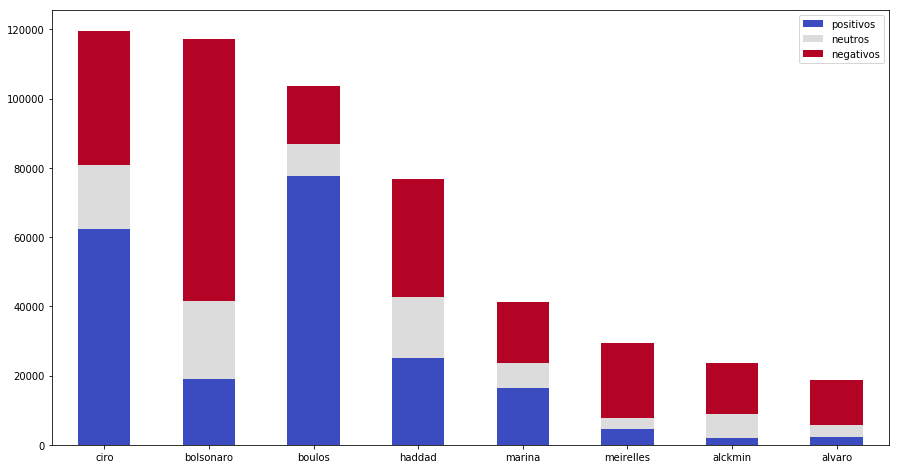

In [28]:
qtde_tweets_df.drop('total', axis=1).plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(15,8), rot=0);

In [75]:
import matplotlib.transforms as mtransforms

def plot_distribuicao_sentimento(df, candidato, factor):
    nome = display_candidatos[candidatos.index(candidato)]
    c = colors[candidatos.index(candidato)]
    df_cand = df[df['text'].apply(lambda x: mask_palavra_texto(candidato, x))]
    for hora in [22, 23, 0]:
        fig, ax = plt.subplots(figsize=(15, 2))
        to_plot = df_cand[df_cand['hour']==hora]['minute'].value_counts().sort_index().reset_index()
        _ = sns.lineplot(x='index', y='minute', data=to_plot, ax=ax, color=c, label=nome, linewidth=5)

        df_pos = df_cand[(df_cand['hour']==hora) & (df_cand[candidato]==1)]['minute'].value_counts().sort_index().reset_index()
        _ = sns.lineplot(x='index', y='minute', data=df_pos, ax=ax, color='blue', label='Positivo', linewidth=2)

        df_neg = df_cand[(df_cand['hour']==hora) & (df_cand[candidato]==-1)]['minute'].value_counts().sort_index().reset_index()
        _ = sns.lineplot(x='index', y='minute', data=df_neg, ax=ax, color='red', label='Negativo', linewidth=2)

        _ = ax.set(xlabel='Minutos ({0}h)'.format(hora),
                   ylabel='Quantidade de tweets',
                   xticks=list(range(0, 60, 1)),
                   yticks=list(range(0, 1_500, 200)),
                   ylim=[0, 1_600])

        _ = ax.legend()
        _ = ax.grid(True)
        _ = ax.axhline(to_plot['minute'].mean())
        
        x=to_plot['index']
        y=to_plot['minute']
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        theta = (to_plot['minute'].mean())*factor
        _ = ax.axhline(-theta, color='red', lw=2, alpha=0.5)
        _ = ax.fill_between(x, 0, 1, where=y > theta, facecolor='red', alpha=0.2, transform=trans)

        _ = sns.despine()
    _ = plt.subplots_adjust(hspace=0.4)
    
    
def analise_nlp(df_tweets, candidato, hora, minutos_comeco, minutos_fim):
    df_cand = df_tweets[df_tweets['text'].apply(lambda x: mask_palavra_texto(candidato, x))]
    df = df_cand[(df_cand['hour']==hora) & ((df_cand['minute']>=minutos_comeco) & (df_cand['minute']<=minutos_fim))].copy()
    df_spacy = nlp(str(df['text']))
    nome = display_candidatos[candidatos.index(candidato)]
    verbos = verbos_candidatos(df_spacy, candidato)
    adjetivos = adjetivos_candidatos(df_spacy, candidato)
    print(' Horário:  {0}h{1} as {0}h{2}'.format(hora, minutos_comeco, minutos_fim))
    print(' Presidenciável:  {0}'.format(nome))
    print(' Quantidade de tweets:  {0}'.format(df.shape[0]))
    print(' Verbos mais utilizados:  {0}'.format(verbos))
    print(' Adjetivos mais utilizados:  {0}'.format(adjetivos))
    print('\n')
    if candidato == 'marina':
        candidato = 'marino'
    for verbo in verbos:
        tweets = frases_candidato(df, candidato, verbo[0])
        flag = 0
        if (len(tweets) != 0) and (flag < 3):
            print(' Alguns tweets com o verbo "{0}":'.format(verbo[0]))
            for tweet in tweets:
                print('')
                print(u'\U0001f4ac   {0}'.format(tweet))
            print('\n')
            flag+=1

### Álvaro Dias <a id='alvaro'></a>

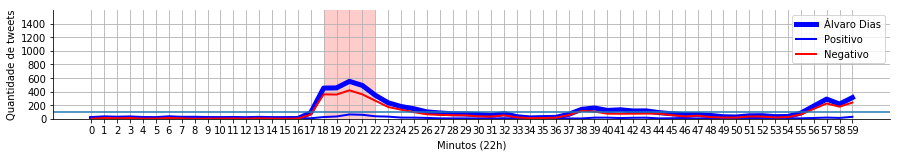

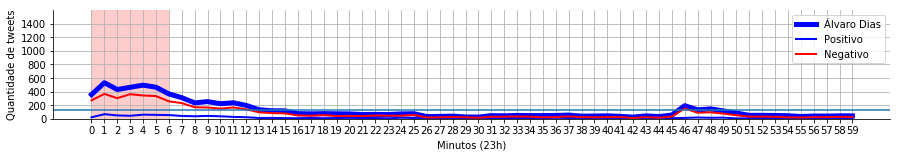

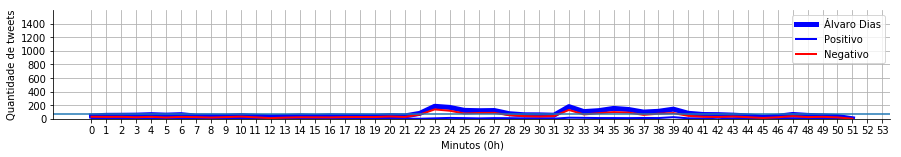

In [52]:
plot_distribuicao_sentimento(full_tweets, 'alvaro', 2.6)

In [56]:
analise_nlp(full_tweets, 'alvaro', 22, 18, 22)

 Horário:  22h18 as 22h22
 Presidenciável:  Álvaro Dias
 Quantidade de tweets:  2296
 Verbos mais utilizados:  [('ficar', 76), ('querer', 45), ('ter', 26), ('beber', 23), ('fazer', 22)]
 Adjetivos mais utilizados:  [(capital, 1), (feliz, 1), (belo, 1), (bêbado, 1), (igual, 1)]


 Alguns tweets com o verbo "ficar":

💬   Beber até ficar doido que nem o Alvaro Dias

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   O ALVARO DIAS ficou elogiando o William Bonner e esqueceu de perguntar e o tempo acabou KKKKKKKKKKKKKKKKKKKKKKKK

pqp mano olha o nivel dos candidatos

#DebateGlobo https://t.co/Mipb5ava0Q

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   alvaro dias passou 2hrs babando o ovo do william bonner que ficou sem tempo pra fazer pergunta, grito


 Alguns tweets com o verbo "querer":

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   Meirelles tem 1 minu

Esta reação no twitter reflete o momento em que o candidato Álvaro Dias extrapolou o tempo para realizar uma pergunta e foi interrompido pelo apresentador William Bonner.

In [57]:
analise_nlp(full_tweets, 'alvaro', 23, 0, 6)

 Horário:  23h0 as 23h6
 Presidenciável:  Álvaro Dias
 Quantidade de tweets:  3108
 Verbos mais utilizados:  [('tomar', 99), ('alguem', 75), ('parecer', 68), ('ter', 63), ('dar', 61)]
 Adjetivos mais utilizados:  [(devido, 1), (uísque, 1), (maior, 1), (sério, 1), (monstruoso, 1)]


 Alguns tweets com o verbo "tomar":

💬   cala a boca alvaro dias vai tomar no cu

💬   O ALVARO DIAS TÁ MAIS LOCO QUE O ROBOCOP TOMANDO BANHO DE MANGUEIRA

💬   A FELICIDADE DO ALVARO DIAS TOMANDO ESPORRO DO BONNER

💬   alvaro dias tomando varios esporros LKKKKKKKKKK #DebateNaGlobo

💬   alguem descobre oq foi q alvaro dias tomou antes do debate pq eu quero um pouco 

#DebateNaGlobo


 Alguns tweets com o verbo "alguem":

💬   alguem descobre oq foi q alvaro dias tomou antes do debate pq eu quero um pouco 

#DebateNaGlobo

💬   alguem descobre oq foi q alvaro dias tomou antes do debate pq eu quero um pouco 

#DebateNaGlobo

💬   Ai gente alvaro, alguem acaba o tempo do alvaro ja

💬   alguem descobre oq foi q alvar

Esta manifestação reflete ao momento em que o candidato Álvaro Dias recebe indicações do apresentador William Bonner para se manter posicionado para a câmera.

**Considerações** <br>
Em geral não foi observado comentários em relação às propostas ou ideais do candidato, foram manifestações decorrentes de acontecimentos não inerentes à política em si.

### Ciro Gomes

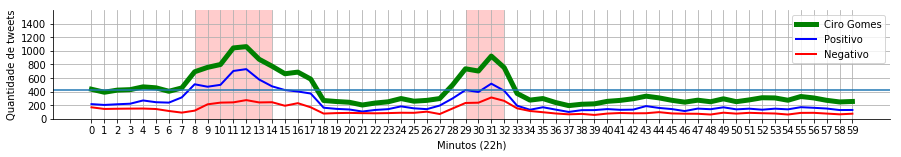

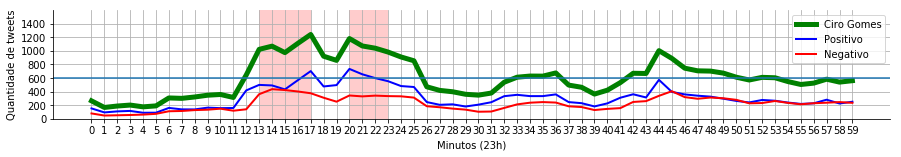

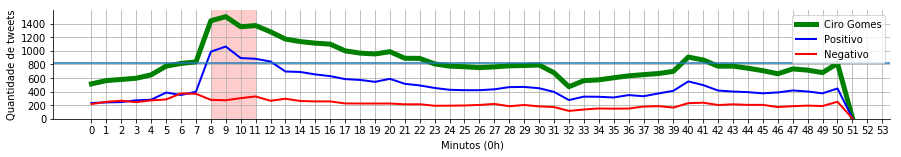

In [60]:
plot_distribuicao_sentimento(full_tweets, 'ciro', 1.6)

In [59]:
analise_nlp(full_tweets, 'ciro', 22, 10, 13)

 Horário:  22h10 as 22h13
 Presidenciável:  Ciro Gomes
 Quantidade de tweets:  3780
 Verbos mais utilizados:  [('votar', 40), ('ter', 39), ('amar', 33), ('querer', 28), ('lindar', 19)]
 Adjetivos mais utilizados:  [(gomes, 1), (sensatas, 1), (primeira, 1), (marina, 1), (real, 1)]


 Alguns tweets com o verbo "votar":

💬   A primeira pergunta do Ciro já me fez sentir orgulho de votar nele

#DebateGlobo https://t.co/j9innHcixY

💬   Ciro: Marina é muito sensata pensa parecido comigo porém sou melhor votem em mim. 

#DebateNaGlobo

💬   Não vote contra o PT ❗

Não vote contra Bolsonaro 🚫

Vote a favor do Brasil 🇧🇷

Vote Ciro 1️⃣2️⃣
 #TsunamiCIRO https://t.co/nC0m7SuQeZ

💬   Bolsonaristas já comemoram provável vitória sobre Haddad!

Novamente, DataFolha mostra que Bolsonaro só perde para Ciro.

Bolsonaro 44% x 43% Haddad 
Ciro 48% x 42% Bolsonaro

Os últimos dias são os mais decisivos!
Está nas suas mãos!
Ainda da tempo!

Vote Ciro 12

 #TsunamiCIRO

💬   ciro p mim ta igual 45, só voto se fo

Esta primeira manifestação referente ao candidato Ciro Gomes no twitter se deu em favor ao seu discurso sobre a polarização da política vivida atualmente no país, onde ele discursou contrário a este cenário.

In [61]:
analise_nlp(full_tweets, 'ciro', 22, 29, 32)

 Horário:  22h29 as 22h32
 Presidenciável:  Ciro Gomes
 Quantidade de tweets:  3116
 Verbos mais utilizados:  [('votar', 50), ('falir', 32), ('falar', 31), ('querer', 29), ('ter', 29)]
 Adjetivos mais utilizados:  [(jovem, 1), (tonico, 1), (facial, 1), (ciro, 1), (útil, 1)]


 Alguns tweets com o verbo "votar":

💬   voto útil &amp; ciro gomes nao cabem na mesma frase

💬   @anabeat05826201 @c410x3 @LCanicali @LEONARDOS0UZA @costaantonios Isso seria triste. Meu voto no Ciro é totalmente… https://t.co/lS0xO7bJH6

💬   Meirelles quase declarando seu voto pro Ciro tá lindo demais kkkkkkkkk

#DebateNaGlobo
#tsunamiCiro

💬   EU SINTO QUE CIRO É O ÚNICO QUE PODE NOS SALVAR VOTEM NO CIRO GENTE #DebateNaGlobo

💬   @cirogomes @r_myrella CIRO EU TE AMO! Eu estou muito triste pq n tirei meu título pra poder votar em vc!!!!


 Alguns tweets com o verbo "falir":

💬   HAHAHAHAHAHAHHAHA CIRO FALA “não existe salvador da pátria” uma piada mesmo hahahahahahahahahahaha

💬   a cada palavra que o ciro fala é

Neste momento o candidato Henrique Meirelles questionou ao candidato Ciro Gomes sobre suas ideias quanto surgimento de um "salvador da pátria", o candidato Ciro Gomes discursou se refereindo novamente à polarização da política e afirmando que "não existe um salvador da pátria". A recepção deste discursou ficou bem dividida entre apoiadores e críticos no twitter.

In [62]:
analise_nlp(full_tweets, 'ciro', 23, 13, 17)

 Horário:  23h13 as 23h17
 Presidenciável:  Ciro Gomes
 Quantidade de tweets:  5416
 Verbos mais utilizados:  [('votar', 80), ('falar', 67), ('passar', 65), ('abreu', 63), ('tava', 53)]
 Adjetivos mais utilizados:  [(difíceis, 1), (ciro, 1), (próximo, 1), (pro, 1), (meio, 1)]


 Alguns tweets com o verbo "votar":

💬   Proximo  tema: pq votar no Ciro 12 #TsunamiCIRO https://t.co/XzWgBn1kec

💬   Boulos, eu vou votar no Ciro pensando em você.

💬   O Ciro disse mesmo que a Katia Abreu é A pessoa pra falar de meio ambiente?

Ele não quer o voto de vocês, amigos. Olha só...

#DebateNaGlobo

💬   minha vó vai votar no ciro ain q orgulho da veinha

💬   VOTA CIRO PORRAAAAAaaaaaaaaa #CiroSim #Ciro12 #CiroNaGlobo #TsunamiCIRO


 Alguns tweets com o verbo "falar":

💬   ciro ta ate rindo de tanto q marina falou da br 163

💬   O Ciro disse mesmo que a Katia Abreu é A pessoa pra falar de meio ambiente?

Ele não quer o voto de vocês, amigos. Olha só...

#DebateNaGlobo

💬   Gosto muito de ouvir o Ciro f

O candidato Ciro Gomes respondeu uma pergunta do candidato Fernando Haddad com a temática de Agronegócio e Meio Ambiente afirmando que confia em sua vice para estes assuntos, esta afirmação gerou uma manifestação no twitter devido às polêmicas em que a sua vice, Kátia Abreu, está envolvida, ela é acusada de graves crimes ambientais sendo, inclusive, detentora de apelidos como "Miss Desmatamento" e "Rainha da Motosserra".

In [63]:
analise_nlp(full_tweets, 'ciro', 23, 20, 23)

 Horário:  23h20 as 23h23
 Presidenciável:  Ciro Gomes
 Quantidade de tweets:  4274
 Verbos mais utilizados:  [('querer', 69), ('votar', 37), ('falar', 34), ('ter', 28), ('tava', 26)]
 Adjetivos mais utilizados:  [(único, 1), (segundo, 1), (#, 1), (ganhar\r\r\nCiro, 1), (civil, 1)]


 Alguns tweets com o verbo "querer":

💬   Ciro trabalhou com Marina, que foi do partido do Haddad (apoiado por Boulos) que elegeu Temer, que chamou o Meirelles e o partido do Alckmin, que teve apoio do Álvaro (congressista há anos como Bolsonaro). Quer renovar? Só tem um: @joaoamoedonovo

💬   Não querem chamar o Ciro e nem o Boulos pq sabem que os 2 comem o cu sem lubrificante mesmo

#DebateNaGlobo https://t.co/WjzSCUBMmp

💬   Resumo do debate:

Haddad: acordou e foi pra briga
Ciro: ninguém quer encarar
Marina: ninguém liga
Alckmin: cumprindo tabela
Meirelles: enfartando
Álvaro Dias: bêbado
Boulos: MELHOR DISCURSO EVER. O BRASIL NÃO TE MERECE!
Bozo: fugiu e tá fazendo monólogo no canal do pastor.

💬   Quer

Foi um debate entre os candidatos Ciro Gomes e Guilherme Boulos com a temática "Combate às drogas", onde ambos produziram discursos que foram bem recebidos pelo público do twitter. Na ocasião ambos os candidatos refutaram as ideias do candidato Jair Bolsonaro referente à segurança pública.

In [64]:
analise_nlp(full_tweets, 'ciro', 0, 8, 11)

 Horário:  0h8 as 0h11
 Presidenciável:  Ciro Gomes
 Quantidade de tweets:  5673
 Verbos mais utilizados:  [('fazer', 57), ('ter', 51), ('olhar', 48), ('votar', 39), ('ganhar', 36)]
 Adjetivos mais utilizados:  [(severo, 1), (brasileiro, 1), (autêntico, 1), (simples, 1), (brasileiro, 1)]


 Alguns tweets com o verbo "olhar":

💬   Olha o Ciro tentando cativar o público feminino.

💬   Pesquisa datafolha:
Bolsonaro: 35%
Haddad: 22%
Ciro: 11%

Eu vou falar uma parada bem seria.   Ciro não cresce a 5 pesquisas. Está a três pesquisas com 11%.
 
Se a esquerda não abrir o olho não vai ter segundo turno para brigar.
Voto útil é  no Haddad sim.

💬   o ciro mencionando a "fraquejada" kkkkk k olha esse homem #DebateNaGlobo

💬   olha o ciro chavecando o bonner kkkkk

💬   O Ciro tava correto! Olha o gráfico das ações da Taurus nos ultimos 6 meses... Já sabemos quem está "lucrando" com o "mito" no poder! #EleJamais #DebateNaGlobo https://t.co/kIBOtsJIhX


 Alguns tweets com o verbo "votar":

💬   JESU

No bloco do debate em questão o tema em que os candidatos confrontaram foi decidido por sorteio por intermédio do apresentador William Bonner, nesta ocasião o apresentador se esqueceu de sortear o tema e o candidato Ciro Gomes o lembrou da tarefa e brincou "Acabei de merecer ganhar o seu voto", uma brincadeira que cativou o público do twitter.

**Considerações**<br>
O candidato Ciro Gomes obteve uma popularidade expressiva no público do twitter, seus picos de manifestações positivas se deu em discursos desaprovando a atual polarização da política e confrontando o candidato Jair Bolsonaro. As manifestações negativas aumentaram no momento em que o candidato relacionou ao tema "Agronegócio e Meio Ambiente" a sua vice Kátia Abreu, alvo de polêmicas em crimes ambientais.

### Fernando Haddad

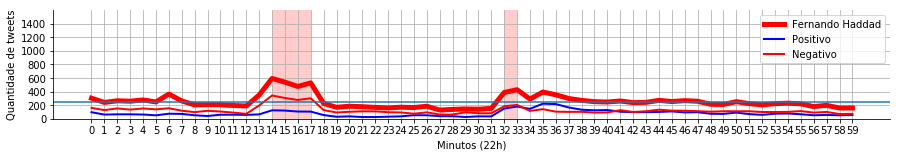

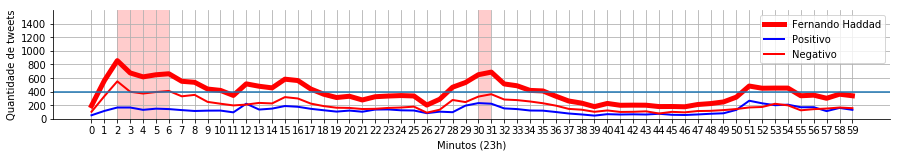

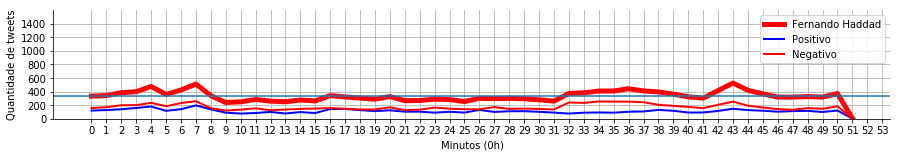

In [68]:
plot_distribuicao_sentimento(full_tweets, 'haddad', 1.5)

In [76]:
analise_nlp(full_tweets, 'haddad', 22, 14, 17)

 Horário:  22h14 as 22h17
 Presidenciável:  Fernando Haddad
 Quantidade de tweets:  2137
 Verbos mais utilizados:  [('ter', 24), ('falar', 22), ('dar', 15), ('querer', 13), ('achar', 12)]
 Adjetivos mais utilizados:  [(haddad, 1), (haddad, 1), (vivo, 1), (segundo, 1), (#, 1)]


 Alguns tweets com o verbo "falar":

💬   meu deus o PT foi o governo + corporativista da história e o haddad acha que tem o direito de falar algo

💬   Haddad falando do governo do FHC 33203838299382 milhões de anos atrás. Eu quero saber do futuro, quero saber da pro… https://t.co/tUzQ3CM0sJ

💬   Haddad falou muito bem. PSDB entre outros partidos ajudaram a acabar com o governo de Dilma e a economia brasileira.

💬   Só eu acho que o Haddad tem preguiça de falar?

💬   Não sei se o Haddad tava falando e olhando pro Alckmin ou pra câmera #DebateNaGlobo


 Alguns tweets com o verbo "querer":

💬   Haddad falando do governo do FHC 33203838299382 milhões de anos atrás. Eu quero saber do futuro, quero saber da pro… https

O candidato Fernando Haddad comentou sobre o governo do Ex-Presidente Fernando Henrique Cardoso afirmando neste governo a carga tributária aumentou e a dívida pública dobrou, o candidato adversário Geraldo Alckmin retrucou afirmando que o governo de Fernando Henrique Cardoso foi 14 anos atrás e não teria qualquer reflexo no cenário atual da economia brasileira. O comentário do candidato Fernando Haddad foi recebido negativamente pelo público do twitter.

In [77]:
analise_nlp(full_tweets, 'haddad', 22, 32, 34)

 Horário:  22h32 as 22h34
 Presidenciável:  Fernando Haddad
 Quantidade de tweets:  1106
 Verbos mais utilizados:  [('ter', 11), ('fazer', 8), ('falar', 7), ('levar', 5), ('achar', 5)]
 Adjetivos mais utilizados:  [(juntos!\r\r\n\r\r\nBoulos, 1), (melhor, 1), (eleitoral, 1), (do, 1), (ok, 1)]


 Alguns tweets com o verbo "falar":

💬   Esse haddad tá fazendo pergunta ou falando do bolsonaro lkkk

💬   #HaddadÉ13 o coiso está na Record falando mal do @LulaOficial e do Haddad ! O coiso mentindo com a maior cara de pau ,dizendo que foi a esquerda que dezuniu o Brasil , comecem a colocar o vídeo desse FDP racista e homofóbico nas redes sociais !

💬   Coloquei na globo e tá o Haddad mentindo e falando merda sobre o bolsonaro. KKKKKKKKKKKKKKKKKK NAO TO ACREDITANDO C… https://t.co/mTcaRpfHNT

💬   Dobradinha entre BOULOS e Haddad não deu mt certo. Mas BOULOS falou certo.

💬   Haddad insiste em falar mal do Temer que foi eleito junto com PT. Se toca cara.   #DebateNaGlobo


 Alguns tweets com o v

Neste momento o candidato Fernando Haddad chamou o candidato Guilherme Boulos para responder a sua pergunta e o questionou sobre seus pensamentos quanto aos candidatos que estão apoiando o governo Temer e principalmente às propostas radicais do candidato Jair Bolsonaro.

In [78]:
analise_nlp(full_tweets, 'haddad', 23, 2, 6)

 Horário:  23h2 as 23h6
 Presidenciável:  Fernando Haddad
 Quantidade de tweets:  3459
 Verbos mais utilizados:  [('querer', 40), ('ficar', 25), ('dar', 23), ('comer', 21), ('botar', 17)]
 Adjetivos mais utilizados:  [(dantesco, 1), (devido, 1), (nervoso, 1), (nervoso, 1), (https://t.co/sb5XYPUNMY, 1)]


 Alguns tweets com o verbo "querer":

💬   e o alvaro dias querendo fazer o haddad de correio elegante

💬   Haddad dando a bronca que a gente queria no Álvaro Dias. Obrigado ícone!

💬   @andreazzaeditor O que Haddad quer dizer quando fala “vocês destruíram” falando da economia?

💬   "eu quero ficar bem de frente pro haddad" KKKKKKKKKKKKKKK mas gente  #DebateNaGlobo

💬   Vamos dar a Resposta para haddad. ele quer saber quem banca a campanha do Bolsonaro, #eutobancando , agora tb quero… https://t.co/Roi1s7M3DY


 Alguns tweets com o verbo "ficar":

💬   MOLEQUE, concordei com o Haddad. Alvaro Dias é um merdão, fica de palhaçada, é cínico. POSTURA POHA

💬   Álvaro dias deu uma catucada no H

Esta manifestação no twitter está atrelada ao momento em que o candidato Fernando Haddad ao responder a pergunta do candidato Álvaro Dias inicia com afirmações sobre o seu comportamento no debate, chamando atenção às diversas vezes em que o candidato Álvaro Dias recebeu recomendações do apresentador William Bonner para manter devidamente posicionado e aos ataques do candidato ao partido PT. O público do twitter, em sua maioria, reagiu com tweets agressivos ao candidato Álvaro Dias.

In [79]:
analise_nlp(full_tweets, 'haddad', 23, 29, 32)

 Horário:  23h29 as 23h32
 Presidenciável:  Fernando Haddad
 Quantidade de tweets:  2383
 Verbos mais utilizados:  [('comer', 34), ('dizer', 28), ('dar', 25), ('ter', 20), ('parecer', 19)]
 Adjetivos mais utilizados:  [(simples, 1), (maior, 1), (haddad, 1), (boa, 1), (político, 1)]


 Alguns tweets com o verbo "comer":

💬   meu deus haddad tem como por nem que seja UM MINUTO largar mão de ser advogado do LULA e fazer uma simples AUTOCRITICA!!!1!!!!!!

💬   marina comendo haddad aovivaço

💬   Namore alguém que fale de vc como o Haddad fala do lula

💬   Marina comendo cu do Haddad ao vivo #DebateNaGlobo

💬   MARINA TÁ COMENDO O CU DO HADDAD ALI #DebateNaGlobo


 Alguns tweets com o verbo "parecer":

💬   meu deus o debate entre ciro boulos e haddad parece uma sauna

-concordo
-é isso mesmo, vou apenas complementar
-muito bem dito

💬   haddad parece cão com raiva, não gostei próximo

💬   Alvaro Dias atacou o PT e a gestão de Fernando Haddad no MEC. Irritado, Haddad acusou o golpe. Dias pare

Esta manifestação em relação ao candidato Fernando Haddad é reflexo da manifestação no mesmo intervalo de tempo em relação à candidata Marina Silva, neste momento a candidata pediu ao candidato suas considerações em relação ao seu partido estar envolvido na polarização política e o candidato a respondeu elogiando o mandato dos 3 últimos governos, todos pelo PT, ao terminar a candidata o acusa de não reconhecer os erros cometidos no governo sob a legenda PT e continuar reiterando estes erros.

**Considerações**<br>
Dos quatro pontos de manifestações encontrados na análise dos tweets em relação ao candidato Fernando Haddad, três deles foram marcados por tweets agressivos, tanto em favor ao candidato, quanto contra. Nestes três pontos de manifestações o assunto central foi o seu partido e a repercussão dos governos anteriores sob a legenda do partido e da polarização política atual.

### Geraldo Alckmin

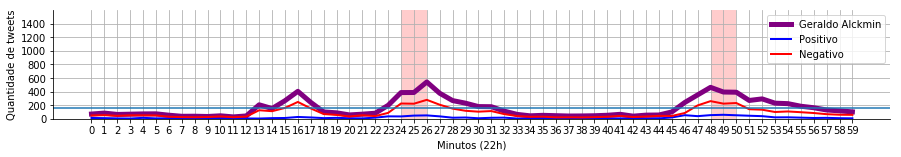

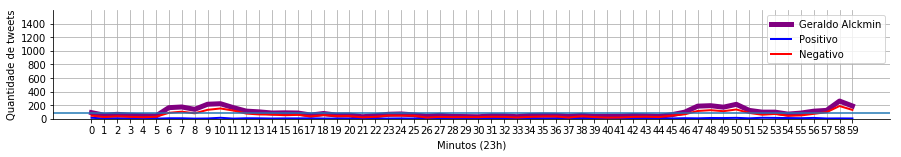

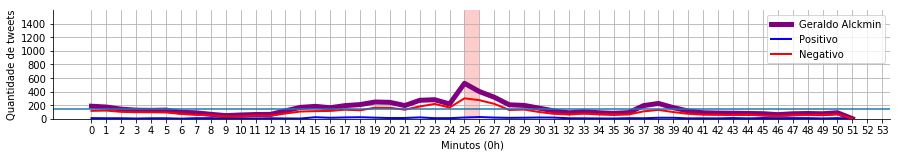

In [95]:
plot_distribuicao_sentimento(full_tweets, 'alckmin', 2.44)

In [96]:
analise_nlp(full_tweets, 'alckmin', 22, 24, 27)

 Horário:  22h24 as 22h27
 Presidenciável:  Geraldo Alckmin
 Quantidade de tweets:  1691
 Verbos mais utilizados:  [('ter', 34), ('falar', 21), ('parecer', 19), ('falir', 16), ('querer', 14)]
 Adjetivos mais utilizados:  [(geraldo, 1), (igual, 1), (https://t.co/8I1LcDYYUd, 1), (necessária, 1), (trabalhista, 1)]


 Alguns tweets com o verbo "falar":

💬   Alckmin falando que a reforma trabalhista foi "necessária" e não retira direitos dos trabalhadores.

meus parabéns… https://t.co/qrTz71xlco

💬   a gente ouve alckmin falando e fica EM SITUAÇÃO DE AGREDIR UM IDOSO

💬   O Alckmin falando da TV do Lula
O Boulos falando de 50 tons de temer
O Ciro falando do Ceará
O Meirelles pedindo pr… https://t.co/CqX6szshj1

💬   Eu ouvindo o Alckmin falando no #DebateNaGlobo https://t.co/IsNpBf079e

💬   alckmin so falando bosta uma coisa q n e novidade ne mores


 Alguns tweets com o verbo "parecer":

💬   É impressão minha ou parece que o Alckmin não tem lábios? Lkkkkkk

💬   a boca do alckmin quando ele 

Esta manifestação se deve ao discurso do candidato Geraldo Alckmin sobre a reforma trabalhista recentemente aprovada, o candidato afirma que a reforma não retirou direitos dos trabalhadores. O público do twitter reagiu negativamente a esta afirmação.

In [97]:
analise_nlp(full_tweets, 'alckmin', 22, 48, 51)

 Horário:  22h48 as 22h51
 Presidenciável:  Geraldo Alckmin
 Quantidade de tweets:  1518
 Verbos mais utilizados:  [('falar', 22), ('falir', 15), ('viver', 12), ('perder', 10), ('ter', 9)]
 Adjetivos mais utilizados:  [(trabalhistas, 1), (insalubres, 1), (inegável, 1), (melhor, 1), (pelo, 1)]


 Alguns tweets com o verbo "falar":

💬   Sinceramente, se eu tô na plateia e o Alckmin começa a falar que fez maravilhas em SP eu levanto, grito "AH, VAI SE… https://t.co/O566auL8M7

💬   Alckmin tinha de falar de bolacha sem receio. Ele sai da merenda, mas a merenda não sai dele.

#DebateNaGlobo

💬   Alckmin falando que vai abaixar imposto sem diminuir o tamanho do estado chega a ser engraçado! #DebateNaGlobo

💬   o cara acabou de falar de 280 bi em desoneração e o alckmin CONTINUA FALANDO EM TIRAR IMPOSTO

💬   Alckmin falou bolacha e não biscoito, to puto


 Alguns tweets com o verbo "falir":

💬   gente eu realmente não acompanho o Alckmin mas pelo o que todo mundo fala dele
MEU AMOR CÊ SÓ FALA

O candidato Geraldo Alckmin discursou sobre a sua atuação como governador do estado de São Paulo, afirmando e citando as reduções de impostos. O público no twitter se manifestou negativamente à essas afirmações.

In [98]:
analise_nlp(full_tweets, 'alckmin', 0, 25, 27)

 Horário:  0h25 as 0h27
 Presidenciável:  Geraldo Alckmin
 Quantidade de tweets:  1240
 Verbos mais utilizados:  [('falar', 29), ('ter', 16), ('entender', 12), ('falir', 10), ('achar', 10)]
 Adjetivos mais utilizados:  [(comum, 1), (primeira, 1), (#, 1), (maior, 1), (@sos_catie, 1)]


 Alguns tweets com o verbo "falar":

💬   Que bonito isso que  o Alckmin falou do filho que a mãe ama mais poetisou

💬   @mizanzuk Juro que quando o Alckmin falou, "olha, Álvaro, nós temos em comum..." eu pensei "a surra que demos nos professores".

💬   Alckmin, ladrão de merenda, falando que quer ser o presidente dos pequeninos 

A desfaçatez desses ARROMBADOS desconhece limites

💬   óbvio que alckmin nao chamou ciro boulos ou haddad por medo deles falarem das merenda

💬   O ALCKMIN VAI FALAR DO RIO SÃO FRANCISCO MESMO?

#tsunamiCiro
#DebateNaGlobo
#CiroNaGlobo https://t.co/hsQf2knv9i


 Alguns tweets com o verbo "entender":

💬   passo a maior parte do tempo das respostas do alckmin tentand entender onde 

Neste momento da manifestação o candidato Geraldo Alckmin recitou um conto para reforçar sua ideia de, segundo suas próprias palavras, "ser o presidente da primeira infância". O público no twitter reagiu negativamente devido às acusações de corrupção na merenda escolar em que o candidato é alvo.

**Considerações**<br>
Este candidato teve ao longo do debate, em sua maioria, tweets carregados de sentimentos negativos, a princípio este cenário parece acontecer devido às acusações de corrupção que este candidato sofreu enquanto era governador do estado de São Paulo.

### Henrique Meirelles

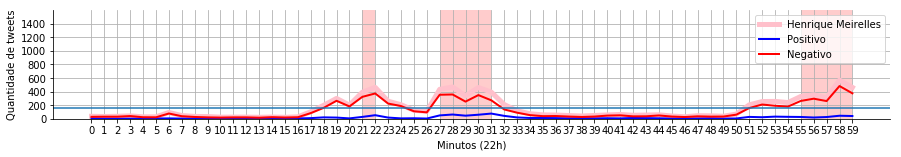

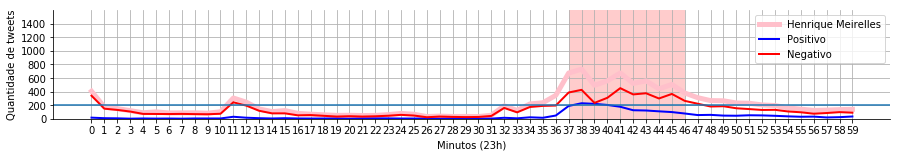

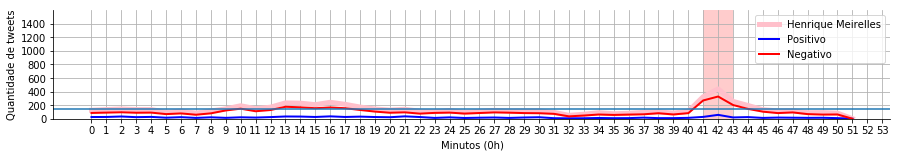

In [106]:
plot_distribuicao_sentimento(full_tweets, 'meirelles', 1.8)

In [107]:
analise_nlp(full_tweets, 'meirelles', 22, 21, 23)

 Horário:  22h21 as 22h23
 Presidenciável:  Henrique Meirelles
 Quantidade de tweets:  1113
 Verbos mais utilizados:  [('chamar', 51), ('ter', 31), ('parecer', 22), ('saber', 11), ('rir', 11)]
 Adjetivos mais utilizados:  [(aaaaaaaa, 1), (https://t.co/cqstf1PcmD, 1), (3879, 1), (impagável, 1), (boas, 1)]


 Alguns tweets com o verbo "chamar":

💬   pode chamar o meirelles que ele não vai resolver problema nenhum kkkkkkk

💬   Até o Meirelles acha esse slogan “Chama o Meirelles” uma piada. Kkkkkk ele falou e segurou o riso kkkkkk #DebateGlobo

💬   Álvaro Dias gastou todo o tempo louvando a Globo e criticando o Lula e faltou tempo para o principal, a pergunta ao Meirelles. Em jornalismo, isso se chama "nariz de cera" #DebateNaGlobo

💬   Dois gagás. Álvaro Dias (Coringa) perdeu o tempo da pergunta.. Para seu colega. CHAMA o Meirelles kkk. Quem é mais… https://t.co/xHgrtmgDQH

💬   Eu não aguento mais ouvir "chama o Meirelles" meu deus


 Alguns tweets com o verbo "parecer":

💬   o meirelles 

O candidato Henrique Meirelles iniciou seu discurso com o seu *slogan* de campanha "Chama o Meirelles". O público no twitter pareceu reagir negativamente.

In [108]:
analise_nlp(full_tweets, 'meirelles', 22, 27, 31)

 Horário:  22h27 as 22h31
 Presidenciável:  Henrique Meirelles
 Quantidade de tweets:  2094
 Verbos mais utilizados:  [('tava', 53), ('parecer', 34), ('cair', 30), ('ter', 28), ('chamar', 28)]
 Adjetivos mais utilizados:  [(segundo, 1), (cômico, 1), (igual, 1), (pro, 1), (presidenciável, 1)]


 Alguns tweets com o verbo "tava":

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil


 Alguns tweets com o verbo "parecer":

💬   Parece q o meirelles vai ter um ataque do coração

💬   Esse Meirelles parece alguém da familia addams

💬   Meirelles e Álvaro Dias parece aquele papo de dois bêbados no bar em que um fala na

Neste momento o microfone do candidato Henrique Meirelles caiu. Houve manifestações negativas ao candidato.

In [109]:
analise_nlp(full_tweets, 'meirelles', 22, 55, 59)

 Horário:  22h55 as 22h59
 Presidenciável:  Henrique Meirelles
 Quantidade de tweets:  2022
 Verbos mais utilizados:  [('ter', 52), ('parecer', 31), ('falir', 30), ('fazer', 27), ('dar', 21)]
 Adjetivos mais utilizados:  [(vcs, 1), (longas, 1), (#, 1), (legal, 1), (engraçado, 1)]


 Alguns tweets com o verbo "parecer":

💬   o meirelles e o alvaro parece que acabaram de sair da endoscopia

💬   essa dobradinha henrique meirelles alvaro dias ta parecendo aqueles aluno da escolinha do professor raimunfo que nao consegue segurar o riso

💬   gente alguem tira o meirelles meu deus parece uma lesma falando coitado

💬   Meirelles X Álvaro Dias faz Americano X ibis parecer aceitável

💬   essa dobradinha henrique meirelles alvaro dias ta parecendo aqueles aluno da escolinha do professor raimunfo que nao consegue segurar o riso


 Alguns tweets com o verbo "falir":

💬   Meirelles fala devagar pra enrolar ou porque não tem fôlego?

💬   alvaro dias e meirelles os dois a 80 km qual dos dois cospe mai

As manifestações são devido ao momento em que o debate se dá entre o candidato Henrique Meirelles e o candidato Álvaro Dias e, em sua maioria, estão relacionados à postura do candidato.

In [110]:
analise_nlp(full_tweets, 'meirelles', 23, 37, 46)

 Horário:  23h37 as 23h46
 Presidenciável:  Henrique Meirelles
 Quantidade de tweets:  5535
 Verbos mais utilizados:  [('chamar', 112), ('falar', 98), ('dizer', 97), ('fazer', 89), ('parecer', 67)]
 Adjetivos mais utilizados:  [(estranho, 1), (da, 1), (política, 1), (brasileira, 1), (meirelles, 1)]


 Alguns tweets com o verbo "chamar":

💬   “Não vou chamar Meirelles, vou tachar Meirelles” #DebateNaGlobo https://t.co/V5OtbHyxNj

💬   E QUANDO FICA CONFUSO FAZ O BORDÃO: CHAMA U MEIRELLES OU 10 MILHÕES DE EMPREGOS

💬   Não é CHAMA O MEIRELLES, e sim SEGURA O MEIRELLES!
Ele tá quase caindooo

💬   Meirelles chamando o boulos de vagabundo!! Sensacional hahahaha

💬   Meirelles deu um show em cima de Boulos, a ponto de Ciro Gomes chamá-lo para perguntar.


 Alguns tweets com o verbo "falar":

💬   o ciro e o meirelles se juntaram pra falar mal do bolsonaro KKKKKKKKKKKKKK mds, esses vovôs #DebateGlobo

💬   MANO EU N AGUENTO O MEIRELLES FALANDO AAAAAAAA

💬   ATE MEIRELLES FALANDO DO BICARBONARO A

A manifestação se deu no momento em que o debate estava entre o candidato Henrique Meirelles e o candidato Guilherme Boulos, onde o candidato Henrique Meirelles insinua que o candidato Guilherme Boulos não trabalha.

In [111]:
analise_nlp(full_tweets, 'meirelles', 0, 41, 44)

 Horário:  0h41 as 0h44
 Presidenciável:  Henrique Meirelles
 Quantidade de tweets:  1217
 Verbos mais utilizados:  [('chamar', 59), ('ter', 30), ('gritar', 19), ('dizer', 14), ('bolsar', 11)]
 Adjetivos mais utilizados:  [(último, 1), (juntos, 1), (mano, 1), (dominó, 1), (Último, 1)]


 Alguns tweets com o verbo "chamar":

💬   Tem que alguém chamar o Bolso e:

- entra aqui nessa sala
- tem o que aí?
- entra rapidão pra eu te mostrar um negócio

Ele entra e tá lá o Haddad, Ciro, Marina, Alckmin, Meirelles

Aparece o Bonner

- Você está no debate da Globo

Close no rosto do candidato. Uma lágrima escorre

💬   Quão triste deve ser sua vida pra vibrar gritando "chama o Meirelles" na Globo

💬   SENHORES, PELA ÚLTIMA VEZ OUVIMOS "CHAMA O MEIRELLES" O, GLORIA. #DebateNaGlobo

💬   Último debate. Meirelles nunca mais será chamado. #RIP

💬   chamar ou taxar o meirelles eis a questão


 Alguns tweets com o verbo "gritar":

💬   Quão triste deve ser sua vida pra vibrar gritando "chama o Meirelles"

O candidato Henrique Meirelles finaliza sua mensagem final ao eleitor com o seu famoso *slogan* de campanha "Chame o Meirelles".